# [In-class Exercise4.1] Write your own ResNet-18 modules for CIFAR-10
---
## Readme
 - You can find a `[TODO]` label in this Homework by pressing **Ctrl + F** and entering `[TODO]` to search.
 - Goals:
   - Build ResNet-18 blocks from scratch.
   - Evaluate on CIFAR-10 (quantitative + qualitative).
   - Load and compare two checkpoints: VGG16 (Fine-tune on CIFAR-10) vs. ResNet-18 (Fine-tune on CIFAR-10).
   - Visualize feature maps.
   - Analyze which model is better and why?
 - We provide:
    1. the notebook `Exercise4.1.ipynb`
    2. the model architecture `ResNet-18_architecture.png`
    3. the checkpoint `vgg16_cifar10.pth` and `resnet18_cifar10.pth`
 - Refer to the Example first, then come back to complete this exercise

### 1) Install the torchinfo package

In [1]:
!pip -q install torchinfo

### 2) Download the ResNet-18 & VGG16 checkpoint

In [2]:
!gdown 1kOybbsBdp-MtPUxtJsCDpioR9_o061Do
!gdown 1ot6m82KgUslEX1LCBLNWWq1pfIcf-ZcV

Downloading...
From (original): https://drive.google.com/uc?id=1kOybbsBdp-MtPUxtJsCDpioR9_o061Do
From (redirected): https://drive.google.com/uc?id=1kOybbsBdp-MtPUxtJsCDpioR9_o061Do&confirm=t&uuid=205737b1-1d3e-40c8-b40b-e2636929dcac
To: /content/vgg16_cifar10.pth
100% 537M/537M [00:03<00:00, 159MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ot6m82KgUslEX1LCBLNWWq1pfIcf-ZcV
From (redirected): https://drive.google.com/uc?id=1ot6m82KgUslEX1LCBLNWWq1pfIcf-ZcV&confirm=t&uuid=55ce94b8-c4b3-4376-9a35-2643e4918c5f
To: /content/resnet18_cifar10.pth
100% 44.8M/44.8M [00:00<00:00, 226MB/s]


### 3) Imports Packages

In [13]:
import numpy as np
from tqdm import tqdm
from typing import List, Optional
import os, math, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18, ResNet18_Weights, vgg16
from torchvision.models.feature_extraction import create_feature_extractor

import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device =", device)

Device = cuda


### 4) Config, Seed

In [4]:
SEED = 42 #[TODO]
np.random.seed(SEED) #[TODO]
torch.manual_seed(SEED) #[TODO]
if torch.cuda.is_available(): #[TODO]
    torch.cuda.manual_seed_all(SEED) #[TODO]

BATCH_SIZE = 64 #[TODO]
criterion = nn.CrossEntropyLoss() #[TODO]

### 5) Data Process (CIFAR-10)

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

test_tfms = transforms.Compose([
    transforms.Resize(256), #[TODO]
    transforms.CenterCrop(224), #[TODO]
    transforms.ToTensor(), #[TODO]
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) #[TODO]
])

root = "./data"
test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tfms) #[TODO])
classes = test_set.classes

test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True) #[TODO])

print("Test set: ", len(test_set))
print("class number: ", len(classes))
print(classes)

100%|██████████| 170M/170M [00:03<00:00, 47.4MB/s]


Test set:  10000
class number:  10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### 6) Build ResNet18

In [6]:
# -----------------------------
# BasicBlock (2x 3x3 conv)
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False) #[TODO] conv1: 3x3, stride=stride, padding=1, bias=False
        self.bn1 = nn.BatchNorm2d(planes) #[TODO] bn1
        self.relu = nn.ReLU(inplace=True) #[TODO] relu
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) #[TODO] conv2: 3x3, stride=1, padding=1, bias=False
        self.bn2 = nn.BatchNorm2d(planes) #[TODO] bn2
        self.downsample = downsample #[TODO] store downsample module

        # [Optional]: Kaiming init + zero-init last BN for residual branch
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        nn.init.constant_(self.bn2.weight, 0.0)  # makes block start as identity

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv1(x) #[TODO]
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [7]:
# -----------------------------
# ResNet-18
# -----------------------------
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes: int = 10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False) #[TODO] stem must be 7x7, stride=2, padding=3, bias=False; then BN+ReLU+MaxPool(3,2,1)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0]) #[TODO] layers (2,2,2,2) with channel 64/128/256/512 and appropriate strides
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes) #[TODO] fc should output 10 classes (in_features=512*block.expansion)

    def _make_layer(self, block, planes: int, blocks: int, stride: int = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: #[TODO] create downsample if stride!=1 or inplanes!=planes*expansion (1x1 conv + BN)
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False), #[TODO]
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample)) # Not [TODO], but important.
        self.inplanes = planes * block.expansion # Not [TODO], but important.
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes)) # Not [TODO], but important.
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x) #[TODO] stem forward: conv1->bn1->relu->maxpool
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #[TODO] stem forward: layer1->layer2->layer3->layer4
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x) #[TODO] stem forward: avgpool->flatten->fc
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
def resnet18(num_classes: int = 10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes) # [TODO] layers = [2,2,2,2]

def count_trainable(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 7) Load & eval ResNet18 checkpoint

In [9]:
model = resnet18(num_classes=10).to(device)

# Downloaded at root
ckpt_path = 'resnet18_cifar10.pth' # [TODO] replace with your actual checkpoint path.
try:
    state = torch.load(ckpt_path, map_location='cpu')
    sd = state.get('state_dict', state)
    model.load_state_dict(sd, strict=False)
    print(f'Loaded checkpoint from: {ckpt_path}')
except Exception as e:
    print(f'[WARN] Failed to load checkpoint: {e}')
    print('Proceeding with randomly initialized weights...')

print(summary(model, input_size=(1, 3, 224, 224)))

Loaded checkpoint from: resnet18_cifar10.pth
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6     

In [10]:
# [TODO] Add docstrings and type hints
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module):
    # [TODO] Implement evaluation loop
    model.eval() #[TODO]
    total_loss, total_correct, total_num = 0.0, 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad(): #[TODO]
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * imgs.size(0)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_num += imgs.size(0)

            probs = F.softmax(logits, dim=1).detach().cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return total_loss/total_num, total_correct/total_num, all_probs, all_labels

### 8) Precision–Recall Curves

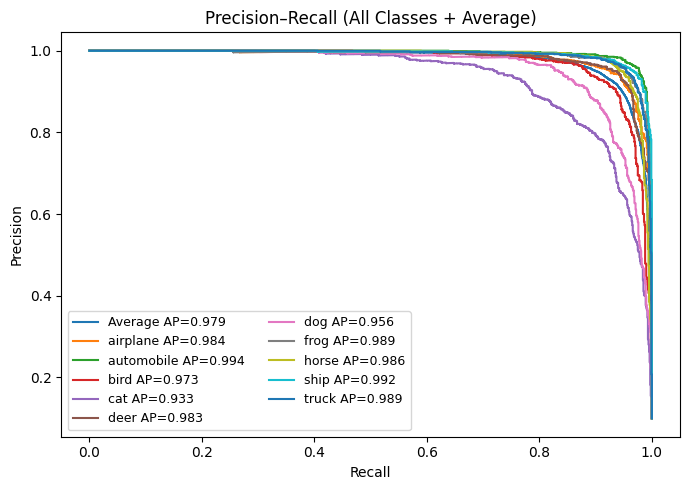

In [11]:
_, _, val_probs, val_labels = evaluate(model, test_loader, criterion)
y_true = val_labels
y_score = val_probs
n_classes = len(classes)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
precision, recall, ap = {}, {}, {}

micro_p, micro_r, _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
ap_micro = average_precision_score(y_true_bin, y_score, average="micro")

plt.figure(figsize=(7,5))
plt.step(micro_r, micro_p, where='post', label=f"Average AP={ap_micro:.3f}")

aps = []
for i in range(n_classes):
    p, r, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    aps.append(ap)
    plt.step(r, p, where='post', label=f"{classes[i]} AP={ap:.3f}")

plt.xlabel("Recall"); plt.ylabel("Precision");
plt.title("Precision–Recall (All Classes + Average)")
plt.legend(ncol=2, fontsize=9, loc='lower left')
plt.tight_layout(); plt.show()

### 9) Report & Confusion Matrix

== Classification Report ==
              precision    recall  f1-score   support

    airplane      0.950     0.928     0.939      1000
  automobile      0.968     0.963     0.965      1000
        bird      0.942     0.892     0.916      1000
         cat      0.813     0.874     0.842      1000
        deer      0.923     0.953     0.938      1000
         dog      0.846     0.919     0.881      1000
        frog      0.958     0.944     0.951      1000
       horse      0.986     0.888     0.934      1000
        ship      0.947     0.970     0.958      1000
       truck      0.964     0.943     0.953      1000

    accuracy                          0.927     10000
   macro avg      0.930     0.927     0.928     10000
weighted avg      0.930     0.927     0.928     10000



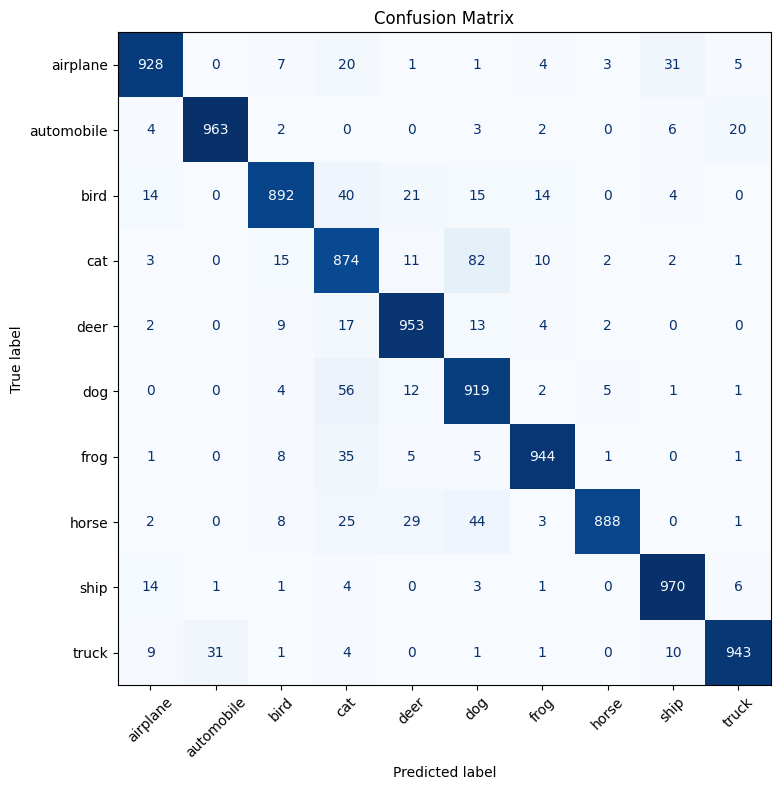

In [14]:
y_pred = np.argmax(y_score, axis=1)
print("== Classification Report ==")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### 10) Visualization: Feature Maps

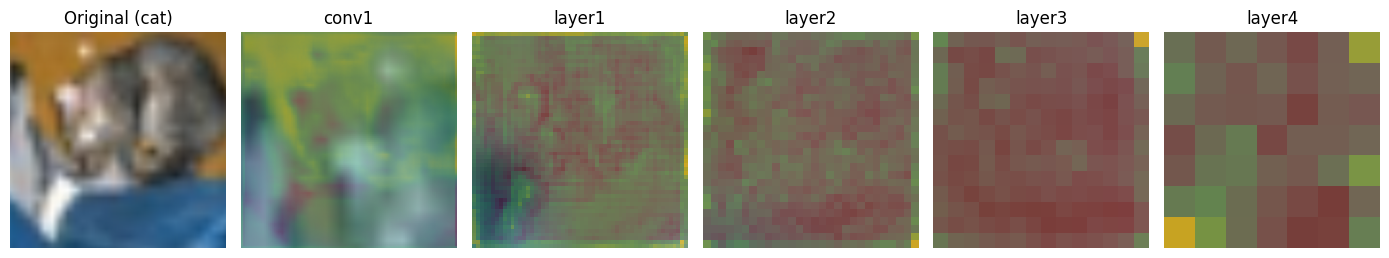

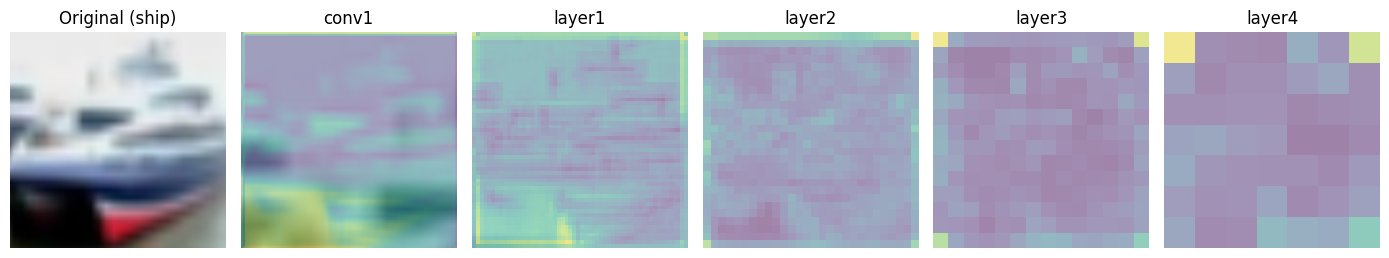

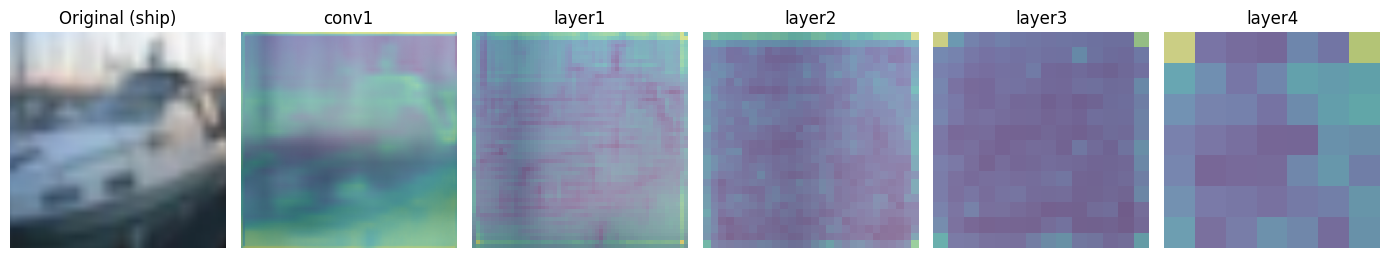

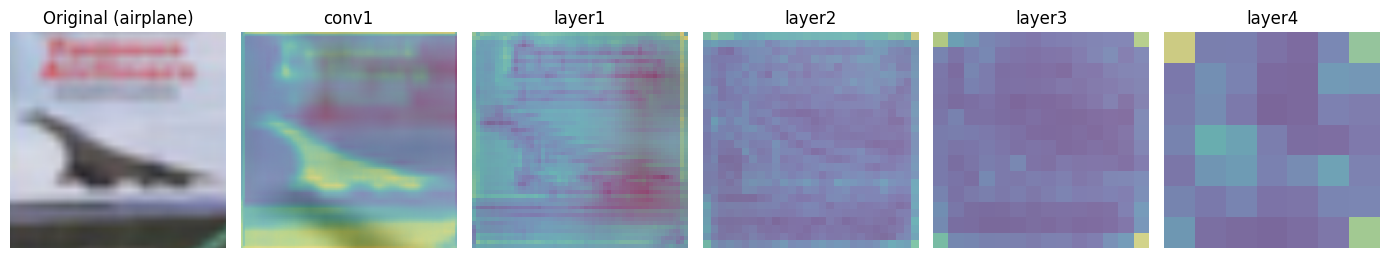

In [15]:
def denorm(img_t):
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1).to(img_t.device)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1).to(img_t.device)
    x = img_t * std + mean
    return x.clamp(0,1)

def _norm_map(m):
    m = m - m.min()
    m = m / (m.max() + 1e-6)
    return m

# Use the first N images from the existing test_loader batch (already 224+ImageNet norm)
N_SHOW = 4 # [TODO]
first_batch_imgs, first_batch_labels = next(iter(test_loader))
sample_imgs_tensor = first_batch_imgs[:N_SHOW].to(device)

# ----- ResNet18 overlays -----
resnet_nodes  = {"conv1":"R_conv1", "layer1.0.relu":"R_l1", "layer2.0.relu":"R_21", "layer3.0.relu":"R_31", "layer4.0.relu":"R_41"} # [TODO]
resnet_titles = ["conv1","layer1","layer2","layer3","layer4"]
resnet_feat = create_feature_extractor(model, return_nodes=resnet_nodes).to(device).eval()

with torch.no_grad():
    r_feats = resnet_feat(sample_imgs_tensor)

for i in range(N_SHOW):
    img_den = denorm(sample_imgs_tensor[i]).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(14,3))
    plt.subplot(1, 6, 1); plt.imshow(img_den); plt.axis('off');
    plt.title(f"Original ({classes[first_batch_labels[i]]})")
    for j, key in enumerate(["R_conv1","R_l1","R_21","R_31","R_41"], start=2):
        fmap = r_feats[key][i].detach().cpu()       # (C,H,W)
        heat = _norm_map(fmap.mean(0)).numpy()      # channel-mean
        plt.subplot(1, 6, j)
        plt.imshow(img_den)
        plt.imshow(heat, alpha=0.45)
        plt.axis('off'); plt.title(resnet_titles[j-2])
    plt.tight_layout(); plt.show()

### 11) Load YOUR fine-tuned VGG16 (CIFAR-10)
 - Upload 'vgg16_cifar10.pth' in the left Files panel, or change the name.

In [16]:
VGG_CKPT = 'vgg16_cifar10.pth' # [TODO]

def build_torchvision_vgg16(num_classes=10): # [TODO]
    try:
        from torchvision.models import vgg16, VGG16_Weights
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    except Exception:
        model = torchvision.models.vgg16(pretrained=True)
    in_f = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_f, num_classes) # [TODO]
    return model

def build_finetuned_from_ckpt(ckpt_path, num_classes=10, map_location="cpu"): # [TODO]
    model = build_torchvision_vgg16(num_classes=num_classes)
    state = torch.load(ckpt_path, map_location=map_location)
    if isinstance(state, dict) and "state_dict" in state:
        state = {k.replace("model.", "").replace("module.", ""): v for k, v in state["state_dict"].items()}
    model.load_state_dict(state, strict=False)  # strict=False to be tolerant
    return model

if os.path.exists(VGG_CKPT):
    ft_model = build_finetuned_from_ckpt(VGG_CKPT, num_classes=10, map_location=device).to(device).eval() # [TODO]
    print(f"✅ Loaded VGG16 weights: {VGG_CKPT}")
else:
    print(f"⚠️ {VGG_CKPT} not found. Upload it first to fully evaluate VGG16.")

print(summary(ft_model, input_size=(1,3,224,224)))
total_params_vgg = sum(p.numel() for p in ft_model.parameters())
print("VGG16 params =", f"{total_params_vgg/1e6:.2f} M")

# [TODO] Add docstrings and type hints
def eval_model_simple(model: nn.Module, loader: DataLoader):
    # [TODO] Implement evaluation loop
    model.eval() #[TODO]
    all_probs, all_labels = [], []
    total_correct, total_num = 0, 0
    with torch.no_grad(): #[TODO]
        for imgs, labels in tqdm(loader, desc="Eval VGG16", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            probs = F.softmax(logits, dim=1)
            pred = probs.argmax(1)
            total_correct += (pred == labels).sum().item()
            total_num += imgs.size(0)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return total_correct/total_num, np.concatenate(all_probs), np.concatenate(all_labels)

vgg_acc, vgg_probs, vgg_labels = eval_model_simple(ft_model, test_loader)
print(f"VGG16 Test Acc = {vgg_acc*100:.2f}%")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 76.4MB/s]


✅ Loaded VGG16 weights: vgg16_cifar10.pth
Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11        

VGG16 Test Acc = 86.74%


### 12) Compare with ResNet18 (params, accuracy, inference speed)

In [17]:
Res18_model = model.to(device).eval()

def measure_infer_time(model, loader, max_batches=10):
    # [TODO] Add docstrings and type hints
    model.eval() # [TODO]
    nimg, t0 = 0, time.time()
    with torch.no_grad():
        for bi, (imgs, _) in enumerate(loader):
            if bi >= max_batches: break
            imgs = imgs.to(device)
            _ = model(imgs)
            nimg += imgs.size(0)
    t1 = time.time()
    ms_per_img = (t1 - t0) / max(nimg,1) * 1000.0
    return ms_per_img

ms_resnet = measure_infer_time(Res18_model, test_loader, max_batches=10) # [TODO]
ms_vgg  = measure_infer_time(ft_model, test_loader, max_batches=10) # [TODO]

params_resnet = sum(p.numel() for p in Res18_model.parameters())
params_vgg  = sum(p.numel() for p in ft_model.parameters())

resnet_acc, _, _ = eval_model_simple(Res18_model, test_loader)

print("\n== Model Comparison ==")
print(f"ResNet18 Params: {params_resnet/1e6:.2f} M | Test Acc: {resnet_acc*100:.2f}% | Inference: {ms_resnet:.2f} ms/img")
print(f"VGG16  Params: {params_vgg/1e6:.2f} M | Test Acc: {vgg_acc*100:.2f}% | Inference: {ms_vgg:.2f} ms/img")


== Model Comparison ==
ResNet18 Params: 11.18 M | Test Acc: 92.74% | Inference: 2.54 ms/img
VGG16  Params: 134.30 M | Test Acc: 86.74% | Inference: 4.97 ms/img


### 13) Divergent sample gallery
 - Show GT / ResNet18 pred(conf) / VGG16 pred(conf) side-by-side
 - Uses the same test_loader and denorm as above

In [18]:
MAX_VIS = 1000

# [TODO] Add docstrings and type hints
def collect_preds_and_images(resnet: nn.Module, vgg: nn.Module, loader: DataLoader, max_images=MAX_VIS):
    # [TODO], # [TODO] Implement collection loop
    resnet.eval() # [TODO]
    vgg.eval() # [TODO]
    r_pred, r_conf, v_pred, v_conf, y_true, imgs = [], [], [], [], [], []
    seen = 0
    with torch.no_grad(): # [TODO]
        for imgs_b, labels in tqdm(loader, desc="Collect (for qualitative analysis)", leave=False):
            imgs_b_gpu = imgs_b.to(device)

            # ResNet18
            logits_r = Res18_model(imgs_b_gpu)
            probs_r = F.softmax(logits_r, dim=1)
            conf_r, pred_r = probs_r.max(1)

            # VGG16 (fine-tuned)
            logits_v = ft_model(imgs_b_gpu)
            probs_v = F.softmax(logits_v, dim=1)
            conf_v, pred_v = probs_v.max(1)

            r_pred.append(pred_r.cpu().numpy());   r_conf.append(conf_r.cpu().numpy())
            v_pred.append(pred_v.cpu().numpy());   v_conf.append(conf_v.cpu().numpy())
            y_true.append(labels.numpy())

            # Cache denormalized images for display (up to max_images)
            for i in range(imgs_b.size(0)):
                if seen >= max_images: break
                img_den = denorm(imgs_b[i]).permute(1,2,0).cpu().numpy()
                imgs.append(img_den); seen += 1
            if seen >= max_images:
                break

    r_pred = np.concatenate(r_pred)[:seen]
    r_conf = np.concatenate(r_conf)[:seen]
    v_pred = np.concatenate(v_pred)[:seen]
    v_conf = np.concatenate(v_conf)[:seen]
    y_true = np.concatenate(y_true)[:seen]
    return r_pred, r_conf, v_pred, v_conf, y_true, imgs

r_pred, r_conf, v_pred, v_conf, y_true_arr, vis_imgs = collect_preds_and_images(Res18_model, ft_model, test_loader, max_images=MAX_VIS)

# [TODO] Logical Problems: r_pred=ResNet, v_pred=VGG, y_true_arr=GT
idx_both_correct = np.where((r_pred == y_true_arr) & (v_pred == y_true_arr))[0] #[TODO]
idx_resnet_only = np.where((r_pred == y_true_arr) & (v_pred != y_true_arr))[0] #[TODO]
idx_vgg_only   = np.where((r_pred != y_true_arr) & (v_pred == y_true_arr))[0] #[TODO]
idx_both_wrong  = np.where((r_pred != y_true_arr) & (v_pred != y_true_arr))[0] #[TODO]

Counts — both correct=833, ResNet✓/VGG✗=91, VGG✓/ResNet✗=32, both wrong=44, Total=1000


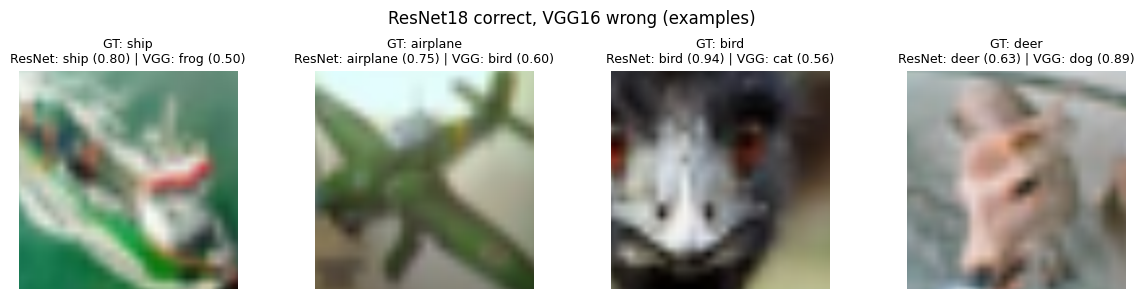

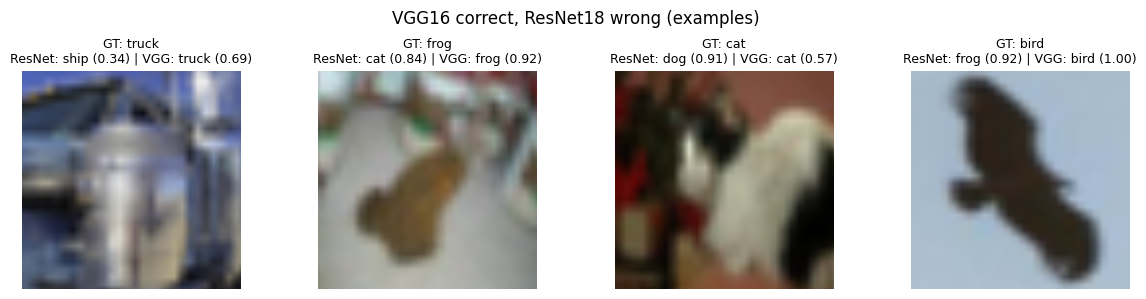

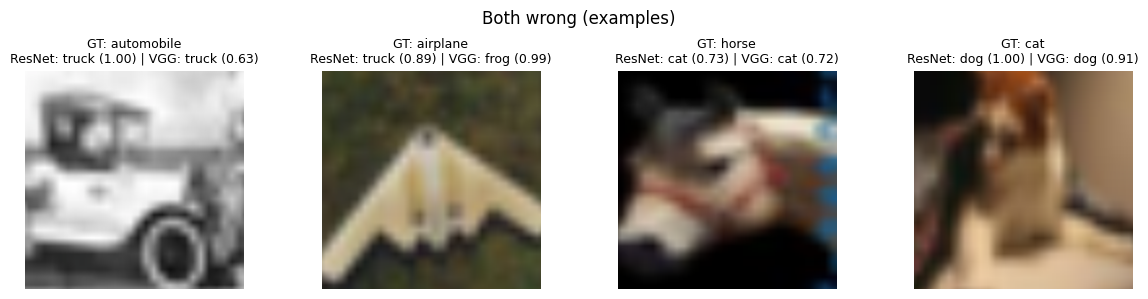

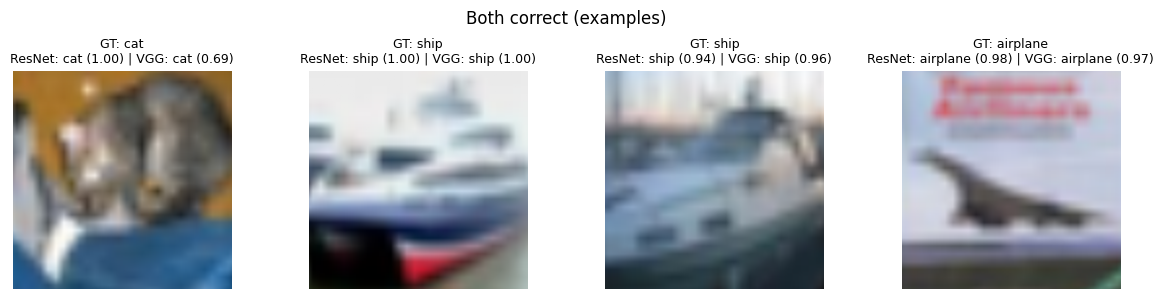

In [19]:
def show_gallery(indices, title, k=12):
    k = min(k, len(indices))
    if k == 0:
        print(f"[{title}] No samples to show.")
        return
    sel = indices[:k]
    cols = 4
    rows = int(np.ceil(k/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for j, idx in enumerate(sel, 1):
        plt.subplot(rows, cols, j)
        plt.imshow(vis_imgs[idx]); plt.axis('off')
        gt = f"GT: {classes[y_true_arr[idx]]}"
        rn = f"ResNet: {classes[r_pred[idx]]} ({r_conf[idx]:.2f})"
        vg = f"VGG: {classes[v_pred[idx]]} ({v_conf[idx]:.2f})"
        plt.title(f"{gt}\n{rn} | {vg}", fontsize=9)
    plt.suptitle(title)
    plt.tight_layout(); plt.show()

print(f"Counts — both correct={len(idx_both_correct)}, ResNet✓/VGG✗={len(idx_resnet_only)}, VGG✓/ResNet✗={len(idx_vgg_only)}, both wrong={len(idx_both_wrong)}, Total={MAX_VIS}") #[TODO] you need to follow the descriptions to finish TODO

show_gallery(idx_resnet_only, "ResNet18 correct, VGG16 wrong (examples)", k=4) #[TODO]
show_gallery(idx_vgg_only, "VGG16 correct, ResNet18 wrong (examples)", k=4) #[TODO]
show_gallery(idx_both_wrong, "Both wrong (examples)", k=4) #[TODO]
show_gallery(idx_both_correct, "Both correct (examples)", k=4) #[TODO]

### 14) Top-k high-confidence mistakes
 - For each model, show the mistakes it made with the highest confidence

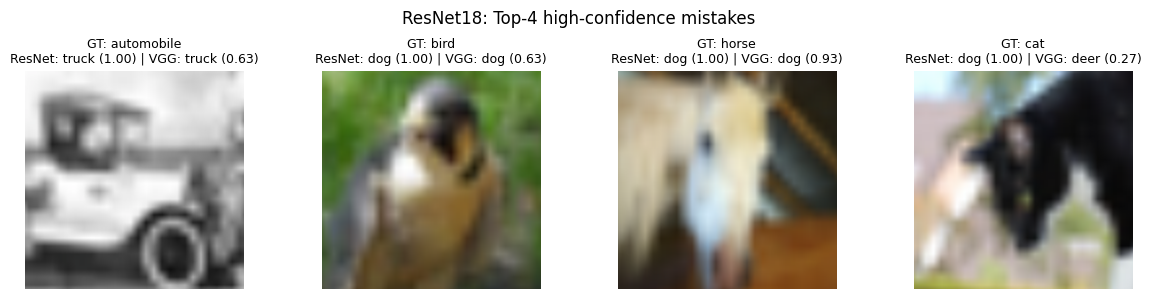

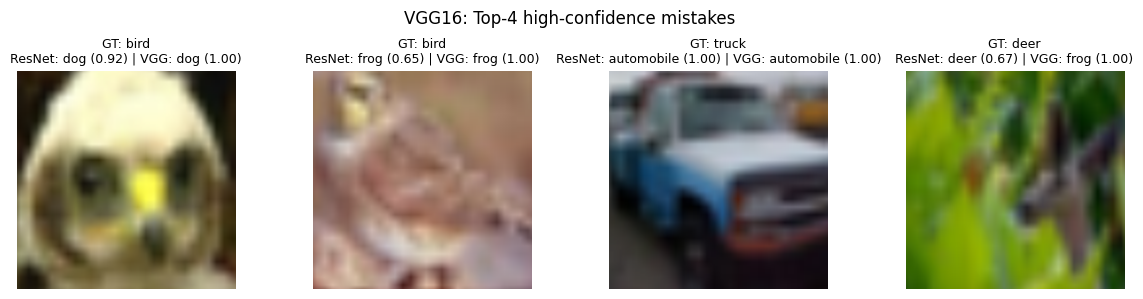

In [20]:
def top_confident_errors(pred, conf, title, k=4):
    wrong = np.where(pred != y_true_arr)[0]
    if len(wrong) == 0:
        print(f"[{title}] No mistakes found.")
        return
    order = wrong[np.argsort(-conf[wrong])]  # descending by confidence
    show_gallery(order, f"{title}: Top-{min(k,len(order))} high-confidence mistakes", k=k)

top_confident_errors(r_pred, r_conf, "ResNet18", k=4)
top_confident_errors(v_pred, v_conf, "VGG16",  k=4)

### 15) Layer-wise activation overlays
 - ResNet18: conv1 / layer1 / layer2 / layer3 / layer4
 - VGG16   : features.0 / 5 / 10 / 17 / 24
 - Visualize channel-mean heatmaps over the denormalized image

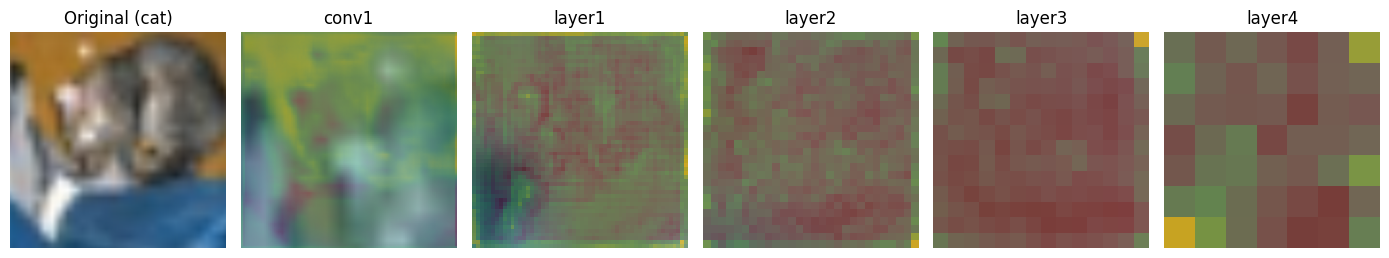

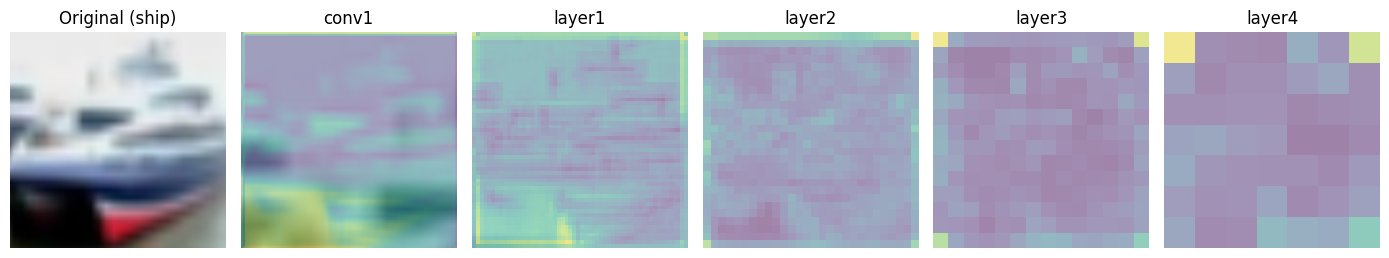

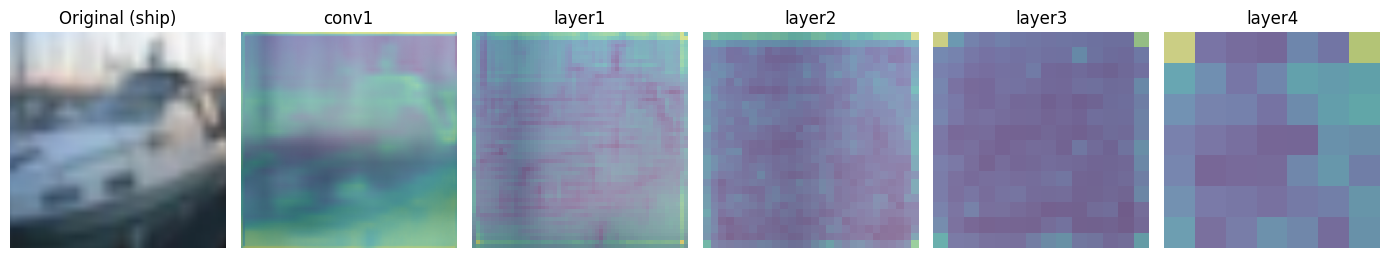

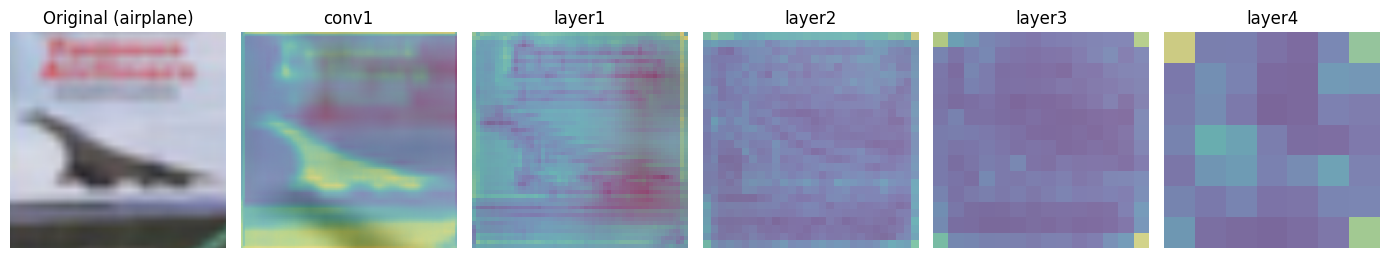

In [21]:
def _norm_map(m):
    m = m - m.min()
    m = m / (m.max() + 1e-6)
    return m

# Use the first N images from the existing test_loader batch (already 224+ImageNet norm)
N_SHOW = 4 # [TODO]
first_batch_imgs, first_batch_labels = next(iter(test_loader))
sample_imgs_tensor = first_batch_imgs[:N_SHOW].to(device)

# ----- ResNet18 overlays -----
resnet_nodes  = {"conv1":"R_conv1", "layer1.0.relu":"R_l1", "layer2.0.relu":"R_21", "layer3.0.relu":"R_31", "layer4.0.relu":"R_41"} # [TODO]
resnet_titles = ["conv1","layer1","layer2","layer3","layer4"]
resnet_feat = create_feature_extractor(model, return_nodes=resnet_nodes).to(device).eval()

with torch.no_grad():
    r_feats = resnet_feat(sample_imgs_tensor)

for i in range(N_SHOW):
    img_den = denorm(sample_imgs_tensor[i]).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(14,3))
    plt.subplot(1, 6, 1); plt.imshow(img_den); plt.axis('off');
    plt.title(f"Original ({classes[first_batch_labels[i]]})")
    for j, key in enumerate(["R_conv1","R_l1","R_21","R_31","R_41"], start=2):
        fmap = r_feats[key][i].detach().cpu()       # (C,H,W)
        heat = _norm_map(fmap.mean(0)).numpy()      # channel-mean
        plt.subplot(1, 6, j)
        plt.imshow(img_den)
        plt.imshow(heat, alpha=0.45)
        plt.axis('off'); plt.title(resnet_titles[j-2])
    plt.tight_layout(); plt.show()

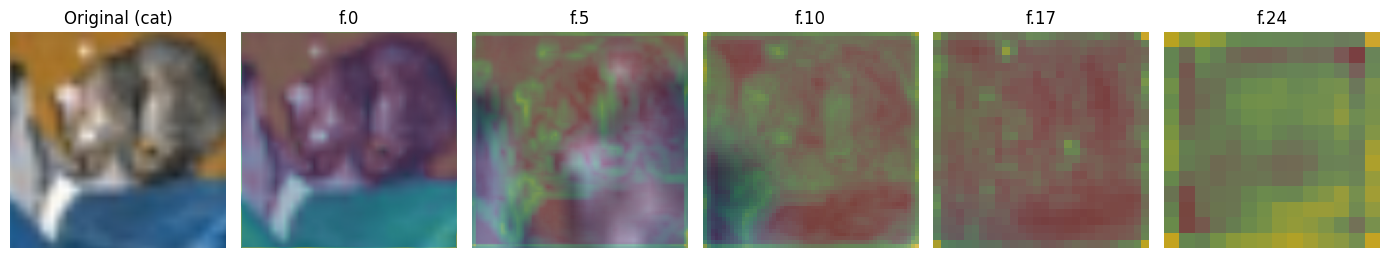

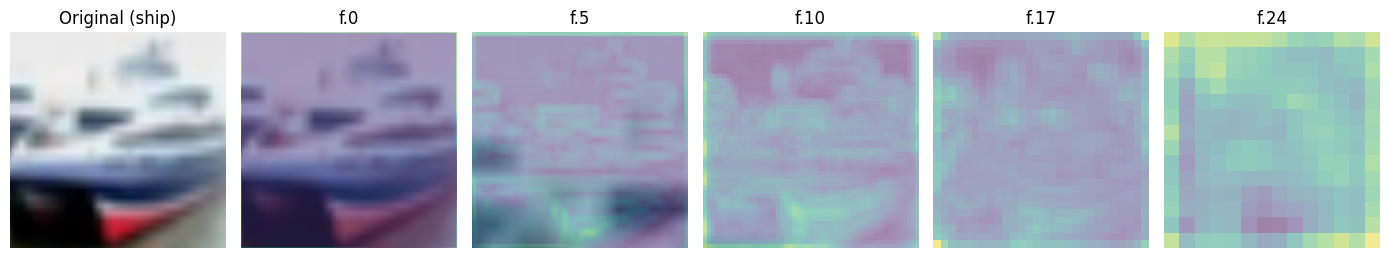

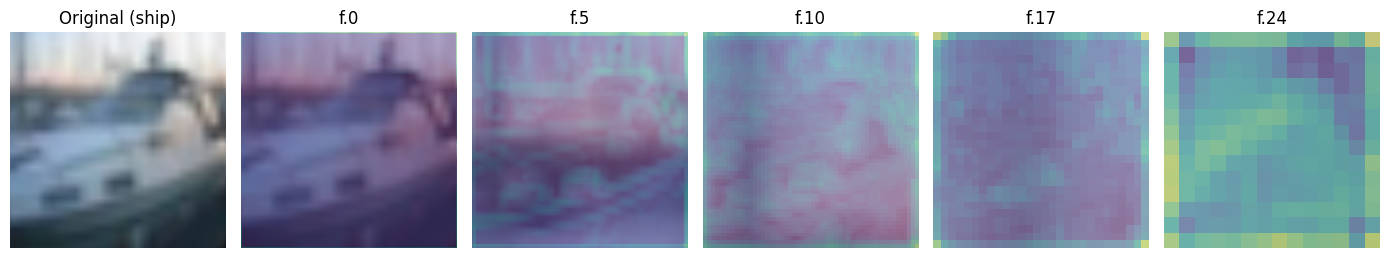

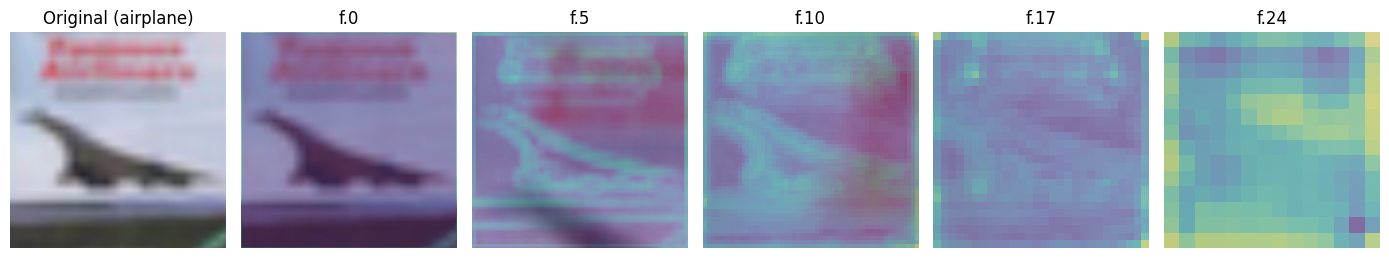

Done: divergent galleries, high-confidence mistakes, and layer-wise overlays for ResNet18 & VGG16.


In [22]:
# ----- VGG16 overlays -----
vgg_nodes  = {"features.0":"V_f0","features.5":"V_f5","features.10":"V_f10","features.17":"V_f17","features.24":"V_f24"} # [TODO] follow above title
vgg_titles = ["f.0","f.5","f.10","f.17","f.24"]
vgg_feat = create_feature_extractor(ft_model, return_nodes=vgg_nodes).to(device).eval()

with torch.no_grad():
    v_feats = vgg_feat(sample_imgs_tensor)

for i in range(N_SHOW):
    img_den = denorm(sample_imgs_tensor[i]).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(14,3))
    plt.subplot(1, 6, 1); plt.imshow(img_den); plt.axis('off');
    plt.title(f"Original ({classes[first_batch_labels[i]]})")
    for j, key in enumerate(["V_f0","V_f5","V_f10","V_f17","V_f24"], start=2):
        fmap = v_feats[key][i].detach().cpu()
        heat = _norm_map(fmap.mean(0)).numpy()
        plt.subplot(1, 6, j)
        plt.imshow(img_den)
        plt.imshow(heat, alpha=0.45)
        plt.axis('off'); plt.title(vgg_titles[j-2])
    plt.tight_layout(); plt.show()

print("Done: divergent galleries, high-confidence mistakes, and layer-wise overlays for ResNet18 & VGG16.")